In [1]:
from __future__ import division

from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML
from utils.prog import log_progress as lp
from matplotlib.patches import Rectangle
from statsmodels.stats import multitest
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from numpy import array as A
import scipy.stats as stats
import sklearn.cluster
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import palettable
import scipy
import sys
import os
sys.stdout.write('.')

%matplotlib inline
%load_ext rpy2.ipython

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors
sns.set_palette(palettable.tableau.ColorBlind_10.hex_colors)
sns.set_style('white')

CONDIR = os.environ.get("CONDIR")

.

### Read in data

In [2]:
connectomes_gsr_all = np.load(os.path.join(CONDIR,'derivatives/connectomes_gsr.npy'))
connectomes_all = np.load(os.path.join(CONDIR,'derivatives/connectomes.npy'))
results_all = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'))
results_all['diagnosis'] = ['psychosis' if x[1].patient==888 else 'healthy control' for x in results_all.iterrows()]
results_all = results_all.drop('Unnamed: 0',axis=1)
cleantable = pd.read_csv(os.environ.get("CLEANTABLE"),sep="\t")
cleantable = cleantable.replace('n/a',np.nan)

for idx,row in results_all.iterrows():
    subid = np.where(row.subject==cleantable.UID)
    results_all.set_value(idx,'MRIQC_score',float(list(cleantable.MRIQC_score.iloc[subid])[0]))

assert(connectomes_all.shape[2]==len(results_all))

In [3]:
def num_subs(results):
    dat = pd.DataFrame({"psychosis":[],"healthy control":[]})
    # number of subjects
    psyid = results.subject[results.patient==888]
    hcid = results.subject[results.patient==999]
    dat = dat.append(
        pd.Series({"psychosis":len(np.unique(psyid)),"healthy control":len(np.unique(hcid))},
                  name="total number of subjects")
    )
    dat = dat.append(
        pd.Series({"psychosis":len(psyid),"healthy control":len(hcid)},
                  name="total number of resting sessions")
    )
    out = dat.to_html()
    return HTML("<h4>Number of subjects/sessions </h4>%s"%out)

num_subs(results_all)

,healthy control,psychosis
total number of subjects,224.0,120.0
total number of resting sessions,896.0,471.0


## 1. Quality measures (without selection)

We have 2 quality measures:
- percentage high-motion time points: we define high-motion time points as points with FD > 0.5mm.
- MRIQC score: based on the T1.  This is of importance for the resting state analyses as to ensure the coregistration is valid.

**Note**: the correlation matrices are based on truncated time series: all time points with high motion, as well as 1 timepoint before and after the high-motion time point are removed.  It has been shown to be a crucial motion cleaning step.

**Note**: if the percentage of timepoints with FD>0.5mm is larger than 20%, then the correlation matrix is not computed.  Those correlation matrices would probably be very invalid.

These results below are before any selection based on quality.

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


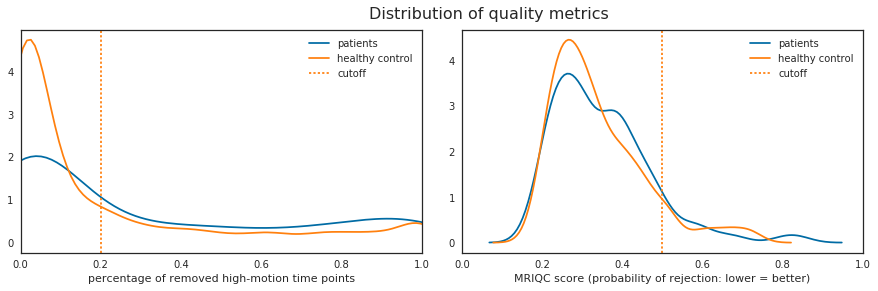

In [4]:
fig = plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.distplot(results_all.percrem[results_all.patient==888],hist=False,label='patients')
sns.distplot(results_all.percrem[results_all.patient==999],hist=False,label='healthy control')
plt.axvline(x=0.2,color=cols[1],label='cutoff',ls=":")
plt.legend()
plt.xlim([0,1])
plt.xlabel("percentage of removed high-motion time points")

plt.subplot(1,2,2)
sns.distplot(results_all.MRIQC_score[results_all.patient==888],hist=False,label='patients')
sns.distplot(results_all.MRIQC_score[results_all.patient==999],hist=False,label='healthy control')
plt.axvline(x=0.5,color=cols[1],label='cutoff',ls=":")
plt.xlim([0,1])
plt.legend()
plt.xlabel('MRIQC score (probability of rejection: lower = better)')

plt.suptitle("Distribution of quality metrics",fontsize=16)
plt.subplots_adjust(left=0,wspace=0.1,top=0.9)

#### Covariance between QA and high-motion timepoints

There is some covariance, which is cool because the QC score is based on the T1 and the high-motion timepoints are based on the resting state data.  In the plot below, each point is a resting state dataset.  Only the orange sessions are held for further analyses (unless otherwise specified).

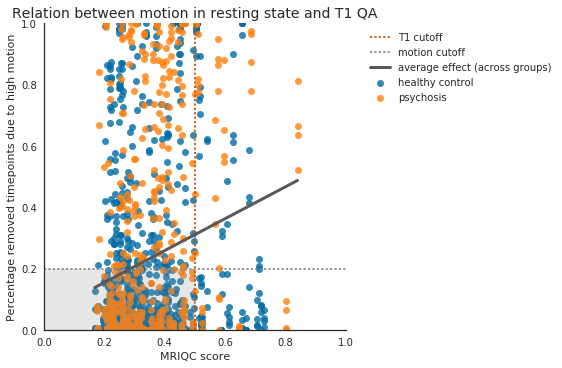

In [5]:
out = smf.ols('percrem ~ MRIQC_score',data=results_all).fit()

sns.lmplot(x='MRIQC_score',y='percrem',data=results_all,hue='diagnosis',fit_reg=False,legend=False)
plt.axvline(x=0.5,color=cols[5],label='T1 cutoff',ls=":")
plt.axhline(y=0.2,color=cols[6],label='motion cutoff',ls=":")
x = np.arange(min(results_all.MRIQC_score),max(results_all.MRIQC_score),0.0001)
plt.plot(x,(out.params[0]+out.params[1]*x),color=cols[3],lw=3,label='average effect (across groups)')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel("MRIQC score")
plt.ylabel("Percentage removed timepoints due to high motion")
plt.title("Relation between motion in resting state and T1 QA",fontsize=14)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0,0), 0.5, 0.2, facecolor=cols[6],alpha=0.2))

## 2.  Average within networks

Below, we take the average of each network-to-network correlations. 

In [6]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"postbids/rest/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = range(333,353)
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*20+['cerebellum']*27
labels = np.unique(labelnames)
labelnames_unsorted = list(labeltable.Community)+['subcort']*20+['cerebellum']*27

def get_within_network_connectivity(con):
    con_av = np.zeros([len(labels),len(labels),con.shape[2]])
    idx1 = -1
    for label1 in lp(labels):
        idx1 += 1
        for idx2,label2 in enumerate(labels):
            x1 = np.where(np.array(labelnames_unsorted) == label1)[0]
            x2 = np.where(np.array(labelnames_unsorted) == label2)[0]
            subsel = con[x1,:,:]
            subsel = subsel[:,x2,:]
            if label1==label2: #if within-network connectivity: only average top triangle
                upid = np.triu_indices(len(x1))
                av = np.mean(subsel[upid],axis=0)
            else:
                av = np.mean(subsel,axis=(0,1))
            con_av[idx1,idx2,:] = av
    return con_av

con_av_gsr_all = get_within_network_connectivity(connectomes_gsr_all)
con_av_all = get_within_network_connectivity(connectomes_all)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


### First cleaning: percentage of high-motion timepoints < 20 %

Before doing any computations on the correlation matrices, we need to do remove the sessions where more than 20% of the timepoints is removed.  These correlation matrices are too unreliable.  The connectomes are (consciously) not computed when too much motion is present.

In [7]:
QAid = np.where(results_all.MOTION_pass==1)[0]
results = results_all.iloc[QAid]
results['patient_bin'] = ['True' if x==888 else 'False' for x in results['patient']]
results.reset_index()
con_av = con_av_all[:,:,QAid]
con_av_gsr = con_av_gsr_all[:,:,QAid]
num_subs(results)

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,healthy control,psychosis
total number of subjects,188.0,83.0
total number of resting sessions,644.0,281.0


### First cleaning: MRIQC score

The second cleaning involves removing subjects with a problematic MRIQC score

In [8]:
QAid = np.where(np.logical_and(results_all.MRIQC_pass==1,results_all.MOTION_pass==1))[0]
results_qc = results_all.iloc[QAid]
results_qc['patient_bin'] = ['True' if x==888 else 'False' for x in results_qc['patient']]
results_qc.reset_index()

connectomes_gsr_qc = connectomes_gsr_all[:,:,QAid]
connectomes_qc = connectomes_all[:,:,QAid]
con_av_qc = con_av_all[:,:,QAid]
con_av_gsr_qc = con_av_gsr_all[:,:,QAid]
num_subs(results_qc)

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,healthy control,psychosis
total number of subjects,172.0,78.0
total number of resting sessions,593.0,265.0


### What does the average correlation matrix look like (with and without GSR) ?

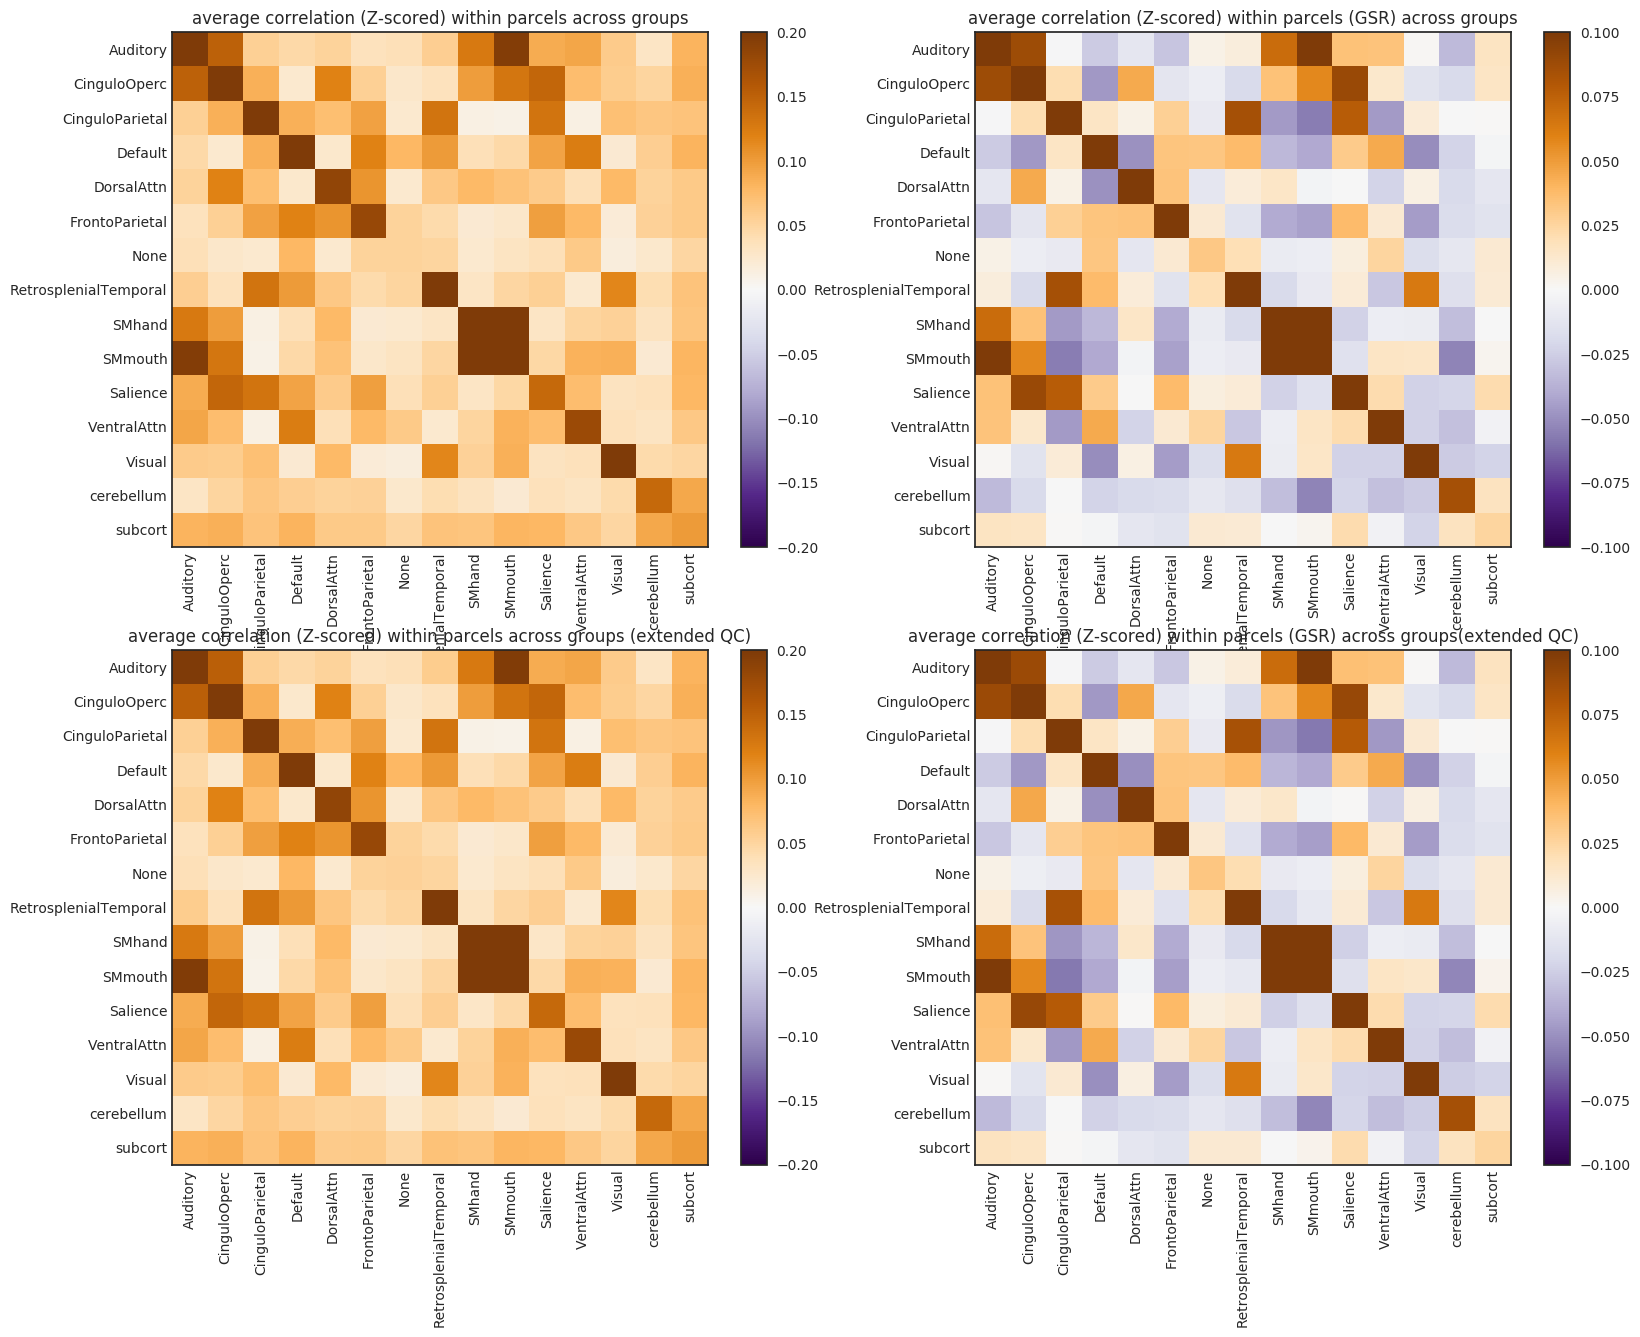

In [9]:
def gordon_network_figure(con,limits=[-0.2,0.2],title="correlation matrix",cmap='PuOr_r',ax=None):
    if ax == None:
        fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
      
    labels_num = np.arange(15)
    major_ticks = np.arange(15)
    minor_ticks = np.arange(15)
    ax1 = ax.imshow(con,cmap = cmap,vmin=limits[0],vmax=limits[1],aspect='auto',
                    interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticks([],minor=False)
    ax.set_xticklabels(labels,minor=True,rotation=90)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticks([],minor=False)
    ax.set_yticklabels(labels,minor=True)
    plt.colorbar(ax1)
    #plt.tight_layout()

fig = plt.figure(figsize=(19, 15), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)
gordon_network_figure(np.mean(con_av,axis=2),limits=[-0.2,0.2],
                      title="average correlation (Z-scored) within parcels across groups",ax=ax1)
ax2 = fig.add_subplot(222)
gordon_network_figure(np.mean(con_av_gsr,axis=2),limits=[-0.1,0.1],
                      title="average correlation (Z-scored) within parcels (GSR) across groups",ax=ax2)
ax3 = fig.add_subplot(223)
gordon_network_figure(np.mean(con_av_qc,axis=2),limits=[-0.2,0.2],
                      title="average correlation (Z-scored) within parcels across groups (extended QC)",ax=ax3)
ax4 = fig.add_subplot(224)
gordon_network_figure(np.mean(con_av_gsr_qc,axis=2),limits=[-0.1,0.1],
                      title="average correlation (Z-scored) within parcels (GSR) across groups(extended QC)",ax=ax4)

### How do the distribution of the correlations look?
Below the distribution of **all** correlations (averaged within networks) are shown.  As expected, the distribution with GSR is shifted around 0, and the variance is smaller.  There is not an apparent difference between groups.

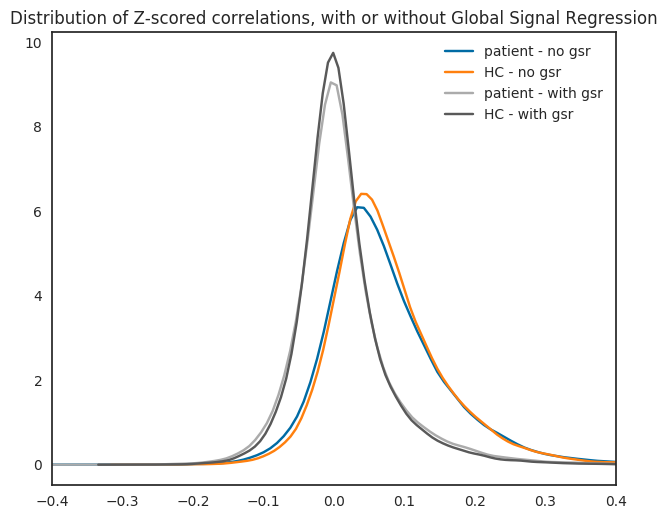

In [10]:
fig = plt.figure(figsize=(16, 6), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(121)
patient = [1 if x==888 else 0 for x in results.patient]
sns.distplot(con_av[:,:,np.where(A(patient)==0)[0]].flatten(),
             hist=False,label='patient - no gsr',kde_kws={"bw":0.01})
sns.distplot(con_av[:,:,np.where(A(patient)==1)[0]].flatten(),
             hist=False,label='HC - no gsr',kde_kws={"bw":0.01})
sns.distplot(con_av_gsr[:,:,np.where(A(patient)==0)[0]].flatten(),
             hist=False,label="patient - with gsr",kde_kws={"bw":0.01})
sns.distplot(con_av_gsr[:,:,np.where(A(patient)==1)[0]].flatten(),
             hist=False,label="HC - with gsr",kde_kws={"bw":0.01})
plt.xlim([-0.4,0.4])
plt.title("Distribution of Z-scored correlations, with or without Global Signal Regression")


## 3. Statistical differences between the groups.

Below, I'm doing a mass univariate comparison between the two groups in a linear mixed model (random intercept per subject), with R's lme4

In [11]:
#check if all connectomes have values
assert(np.sum(np.mean(con_av_gsr,axis=(0,1))==0)==0)

incon = [con_av_gsr,con_av_gsr_qc,con_av,con_av_qc]
inpat = [results.patient,results_qc.patient,results.patient,results_qc.patient]
insub = [results.subject,results_qc.subject,results.subject,results_qc.subject]
titles = ['with gsr','with gsr - additional QC','without gsr','without gsr - additional QC']

In [12]:
%%R -i incon,inpat,insub -o outT,outP

library(lme4)

outT <- array(NA,dim=c(15,15,4))
outP <- array(NA,dim=c(15,15,4))

for (con in 1:4){    
    for (idx in 1:15){
        for(idy in 1:15){
            if (idx==idy){
                outT[idx,idy,con] <- 0
                outP[idx,idy,con] <- 1
            }
            if (idx>idy){
                outT[idx,idy,con] <- outT[idy,idx,con]   
                outP[idx,idy,con] <- outP[idy,idx,con]   
            } else {
                newdat <-  data.frame(inpat[[con]],insub[[con]],incon[[con]][idx,idy,])
                colnames(newdat) <- c("patient","subject","conn")
                model <- lmer(conn ~ patient + (1|subject),data=newdat)
                tval <- -coef(summary(model))[2,3]
                pval <- 2*(1-pnorm(abs(tval)))
                outT[idx,idy,con] <- tval
                outP[idx,idy,con] <- pval
            }
        }
    }   
}

/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


Below the results can be seen.  The distribution of the T-values with global signal regression is a lot wider.  This indicates that the variance within the groups (and or within subjects) diminishes, which increases the estimated variance between the groups.  This indicates that the global signal regression indeed removes **a lot** of nuisance, and we win power.

Below are the T-maps of the connectomes.  It shows that indeed the patterns are similar, but much stronger. A lot of the effects change direction...

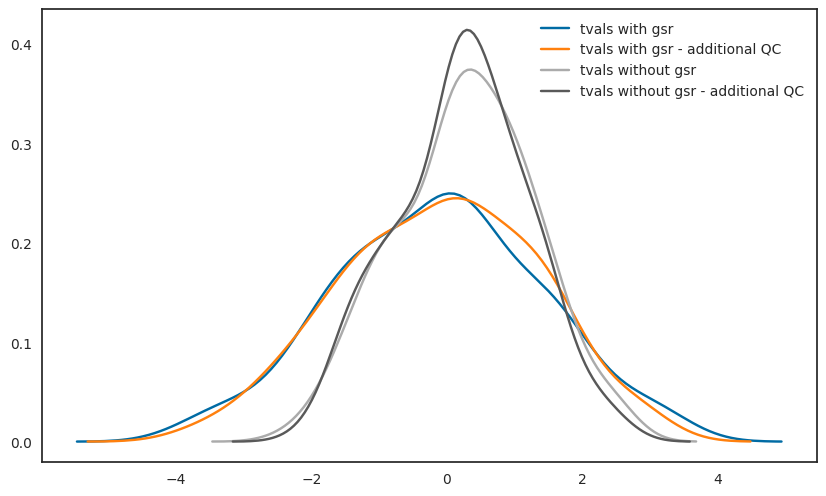

In [13]:
fig = plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')

for k in range(4):
    sns.distplot(outT[:,:,k].flatten(),hist=False,label="tvals %s"%(titles[k]))

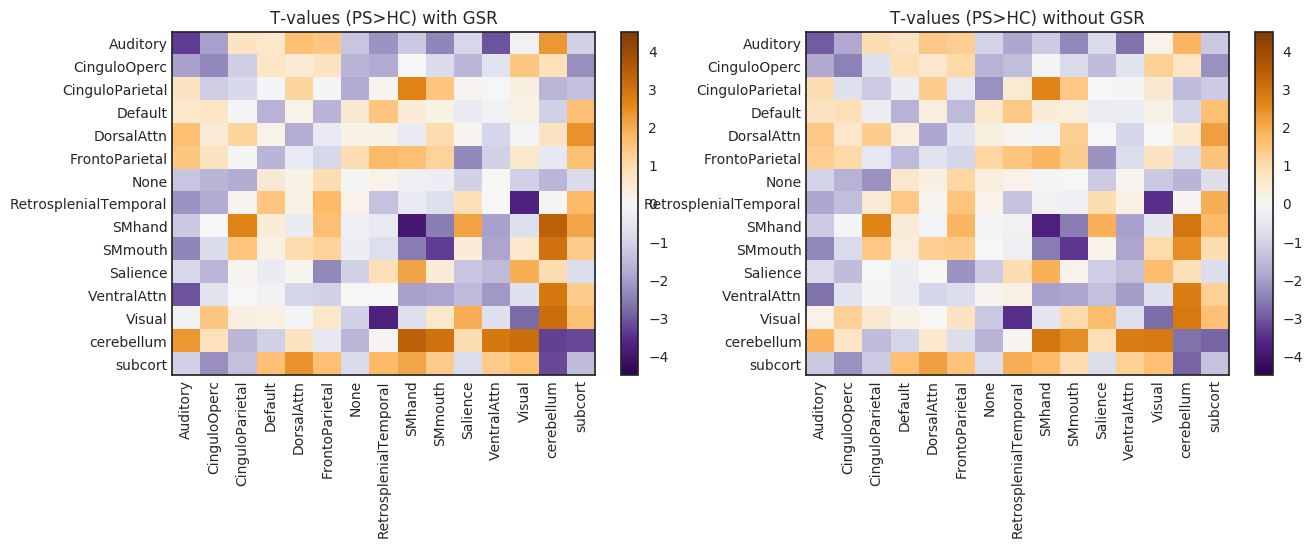

In [14]:
fig = plt.figure(figsize=(15, 10), dpi= 100, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(221)
gordon_network_figure(outT[:,:,0],limits=[-4.5,4.5],title="T-values (PS>HC) with GSR",ax=ax1)
ax2 = fig.add_subplot(222)
gordon_network_figure(outT[:,:,1],limits=[-4.5,4.5],title="T-values (PS>HC) without GSR",ax=ax2)

In [15]:
# thresholding w FDR
upid = np.triu_indices(15)
thresholds = []
for k in range(4):
    pvals = outP[:,:,k][upid]
    tvals = outT[:,:,k][upid]
    hlp = (np.argsort(pvals).argsort()+1)/len(pvals)*0.05
    #sig_t = multipletests(pvals,method='fdr_bh')[0]
    sig = pvals<hlp
    if np.sum(sig)>0:
        threshold = np.min(abs(tvals[sig]))
    else:
        threshold = 0
    thresholds.append(threshold)

In [16]:
def make_cmap(limit,threshold):
    gn = palettable.colorbrewer.sequential.GnBu_5.mpl_colors[1]
    bu = palettable.colorbrewer.sequential.GnBu_5.mpl_colors[4]
    g1 = palettable.colorbrewer.sequential.Greys_5.mpl_colors[0]
    g2 = palettable.colorbrewer.sequential.Greys_5.mpl_colors[2]
    yl = palettable.colorbrewer.sequential.YlOrBr_5.mpl_colors[1]
    rd = palettable.colorbrewer.sequential.YlOrBr_5.mpl_colors[4]
    
    thr = (threshold/limit)/2.+0.5
    upper = thr
    lower = 1-upper
    cmap1 =  {'red': 
     [[0.0, None, gn[0]], 
      [lower, bu[0], g1[0]], 
      [upper, g2[0], rd[0]], 
      [1.0, yl[0], None]], 
     'green': 
     [[0.0, None, gn[1]], 
      [lower, bu[1], g1[1]], 
      [upper, g2[1], rd[1]], 
      [1.0, yl[1], None]], 
     'blue': 
     [[0.0, None, gn[2]], 
      [lower, bu[2], g1[2]], 
      [upper, g2[2], rd[2]], 
      [1.0, yl[2], None]]}
    cmap = mcolors.LinearSegmentedColormap("CustomMap",cmap1)
    return cmap

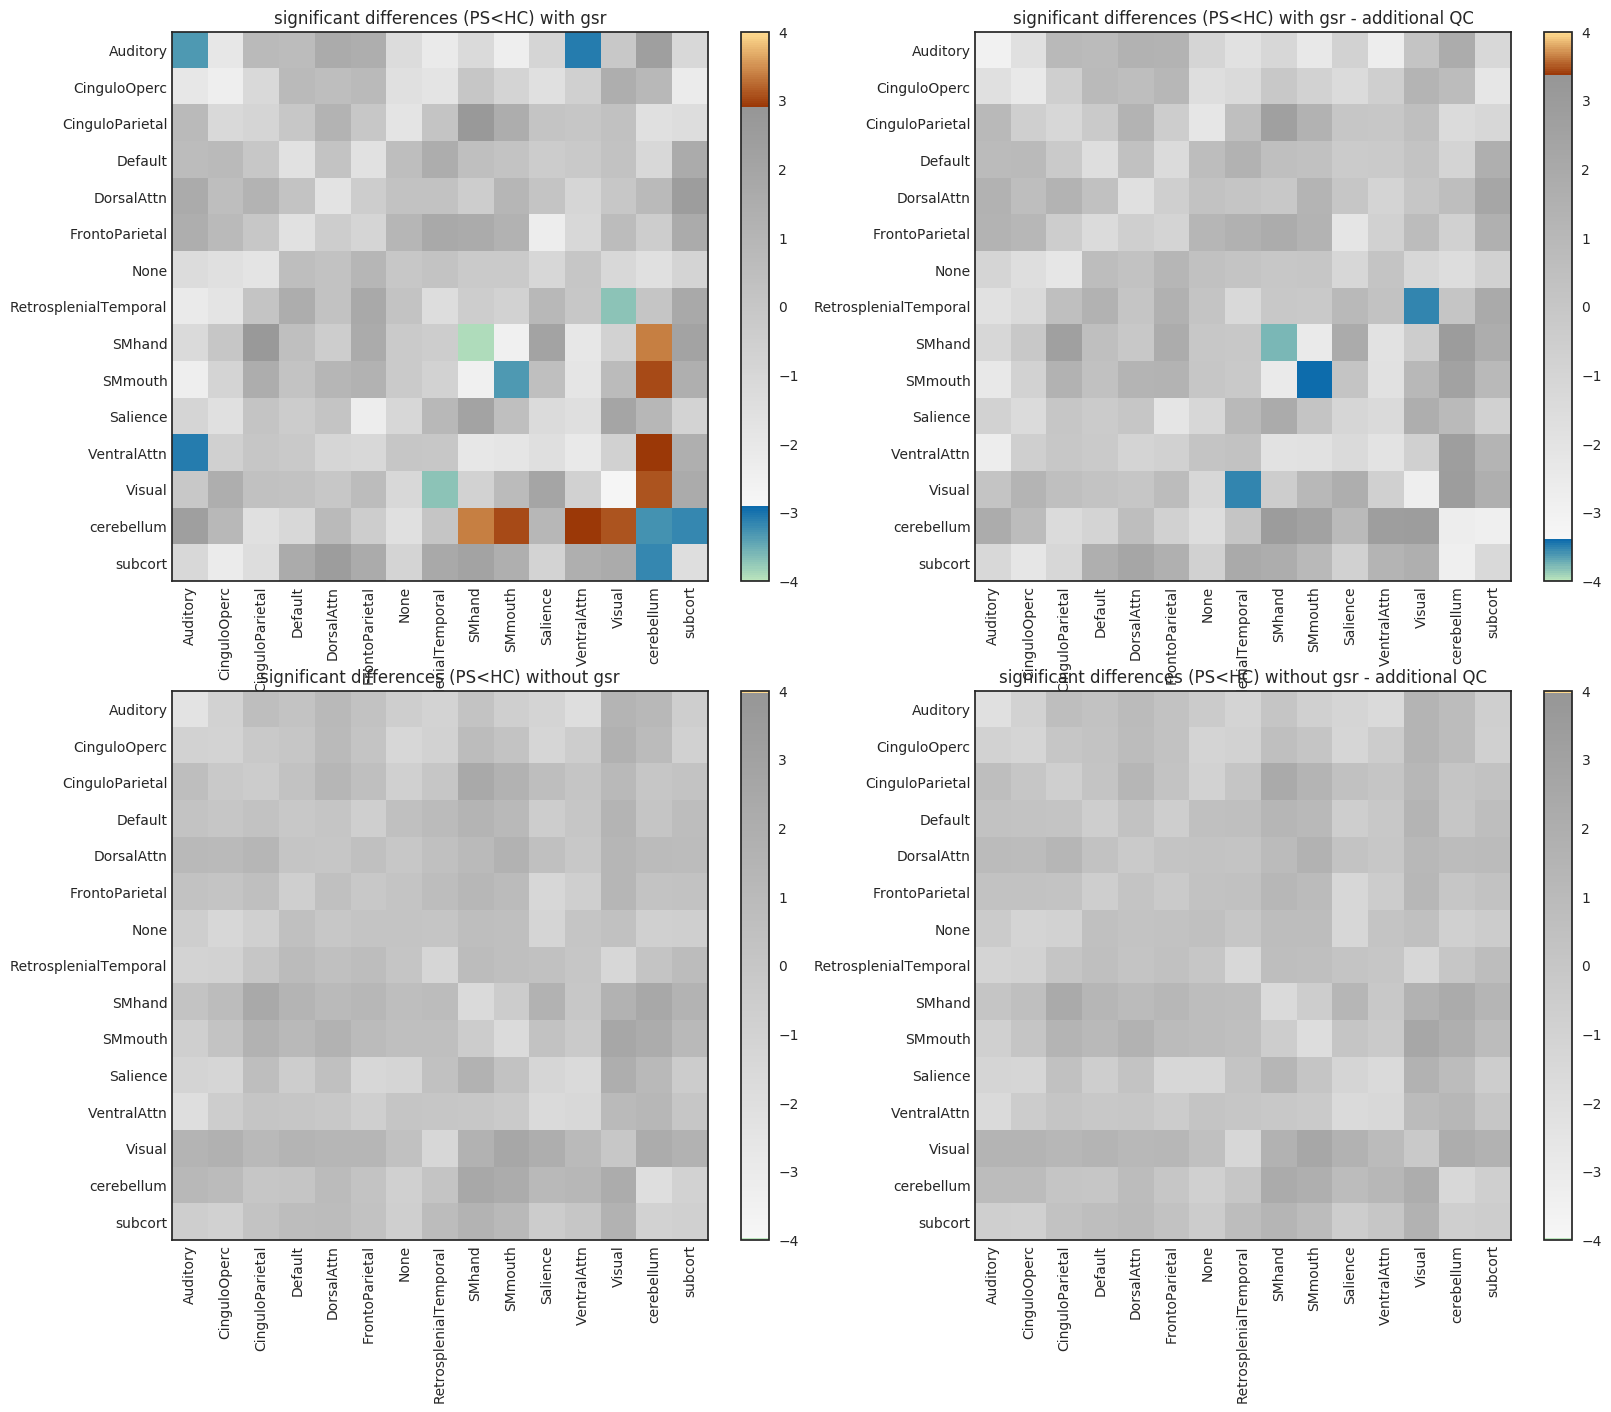

In [17]:
axes = [221,222,223,224]
fig = plt.figure(figsize=(19, 16), dpi= 100, facecolor='w', edgecolor='k')

for tmap in range(4):
    ax = fig.add_subplot(axes[tmap])

    if thresholds[tmap] == 0:
        thr = 4
    else:
        thr = thresholds[tmap]
    cmap = make_cmap(limit=4,threshold=thr)
    gordon_network_figure(outT[:,:,tmap],title='significant differences (PS<HC) %s'%titles[tmap],limits=[-4,4],cmap=cmap,ax=ax)